<a href="https://colab.research.google.com/github/kuri-ai/evaluation/blob/ver2/evaluation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

今後の改修予定</br>
１）推論値のフィルタリング</br>
２）オッズによるフィルタリング</br>
３）テスト値（2021年データ）の対応</br>
４）1位-2位の推論値差によるフィルタリング</br>
５）シャープレシオの評価値導入</br>

In [ ]:
import pandas as pd

# 【設定値１】output_csvのPATHを設定
df_pred = pd.read_csv('/content/drive/MyDrive/bakuto_dataset/model_dart_ver3/A303_01V_output_result.csv',encoding= 'SHIFT-JIS')

# 【設定値２】lawのデータのPATHを設定
df_dataset = pd.read_csv(r'/content/drive/MyDrive/bakuto_dataset/model_dart/dataset_dart_2020.csv',
# df_dataset = pd.read_csv(r'/content/drive/MyDrive/bakuto_dataset/model_dart/dataset_dart_2021.csv',
                         encoding= 'SHIFT-JIS',
                         usecols=['row01_今走_レース_競走コード','row01_今走_レース_開催年','row01_今走_レース_開催月','row01_今走_レース_場コード','row01_今走_レース_月日',
                                  'row01_今走_馬_馬番','row01_今走_馬_確定着順','row01_今走_馬_単勝配当','row01_今走_馬_複勝配当','row01_今走_馬_複勝配当','row01_今走_馬_単勝オッズ','row01_今走_馬_単勝人気','row01_今走_馬_複勝オッズ1','row01_今走_馬_複勝オッズ2'])

# 【設定値３】列名の行を指定　k分割法のデータセットのみ設定
# df_dataset.drop(df_dataset.index[[4918,9330,11436,16295,21397,25136,28951,32157,35642,40379]],inplace=True)

# 型変換
df_dataset['row01_今走_馬_単勝配当'] = df_dataset['row01_今走_馬_単勝配当'].astype(int)
df_dataset['row01_今走_馬_複勝配当'] = df_dataset['row01_今走_馬_複勝配当'].astype(int)
df_dataset['row01_今走_馬_確定着順'] = df_dataset['row01_今走_馬_確定着順'].astype(int)

df_dataset['row01_今走_レース_競走コード'] = df_dataset['row01_今走_レース_競走コード'].astype(float)
df_dataset['row01_今走_レース_競走コード'] = df_dataset['row01_今走_レース_競走コード'].astype(int)

df_dataset['row01_今走_馬_確定着順'] = (df_dataset['row01_今走_馬_確定着順'] - 18)*-1
df_dataset['row01_今走_馬_単勝人気'] = (df_dataset['row01_今走_馬_単勝人気'] - 18)*-1


# レースnoと馬番の昇順でソート
df_dataset.sort_values(by=['row01_今走_レース_競走コード','row01_今走_馬_馬番'],inplace=True)

# 結合キーのカラム名を統一
df_dataset.rename(columns={'row01_今走_レース_競走コード':'race_no','row01_今走_馬_馬番':'uma_no'},inplace=True)

# left-join
df = pd.merge(df_pred,df_dataset,on=['race_no','uma_no'], how='left')

df.drop(columns=['x'],inplace=True)

# 同一レースの期待値順位を算出
# df.rename(columns={'y_1\'':'y\''},inplace=True)
df['期待値順位']=df.groupby(['race_no'])['y\''].rank(ascending=False,method='min')

# 2位との期待値差を追加
df = pd.merge(df,df.query('期待値順位 == 2')[['race_no','y\'']],on=['race_no'], how='left',suffixes=('','_2nd'))
df['dif_rank2'] = df['y\''] - df['y\'_2nd']

# 期待値偏差値の追加
grouped = df.groupby('race_no')
a = grouped['y\''].mean()
b = grouped['y\''].std()
df_sta = pd.merge(a,b,on='race_no',how='inner')
df_sta.set_axis(['mean','std'],axis=1)
df = pd.merge(df,df_sta,on=['race_no'],how='left')
df.rename(columns={'y\'_x':'mean','y\'_y':'std'},inplace=True)
df['期待値偏差値'] = (df['y\'']-df['mean'])/df['std']*10+50

# 期待値順位1～18位のDF作成
arr_rank = []
for i in range(18):
  arr_rank.append(df[df['期待値順位']==(i+1)])

(array([ 16., 137., 324., 337., 191.,  67.,  14.,   7.,   3.,   1.]),
 array([-0.02903576,  0.00612872,  0.0412932 ,  0.07645768,  0.11162216,
         0.14678663,  0.18195111,  0.21711559,  0.25228007,  0.28744455,
         0.32260903]),
 <a list of 10 Patch objects>)

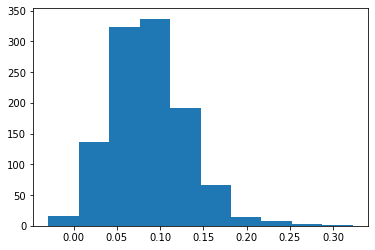

In [ ]:
import matplotlib.pyplot as plt

x = grouped['y\''].mean()
plt.hist(x)

In [ ]:
df.to_csv('20210728_output_result.csv',encoding='SHIFT-JIS',header=True)

from google.colab import files
files.download('20210728_output_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 分析グラフ

In [ ]:
# 期待値順位別の分析
def income_transition(rank,x):

  if x == 'f':
    column_name = 'row01_今走_馬_複勝配当'
  elif x == 't':
    column_name = 'row01_今走_馬_単勝配当'

  fukusyo_arr = arr_rank[rank-1][column_name].dropna().to_list()

  y=[]
  shisan = 10000
  y = [10000]

  for i in fukusyo_arr:
    shisan -= 100
    shisan += i
    y.append(shisan)

  income = sum(fukusyo_arr)
  outcome = len(fukusyo_arr)*100

  income_rate = round(income/outcome * 100,3)


  hit_rate = (len(arr_rank[rank-1][column_name]) - len(arr_rank[rank-1][arr_rank[rank-1][column_name]==0])) / len(arr_rank[rank-1][column_name]) *100
  hit_rate = round(hit_rate,3)

  import matplotlib.pyplot as plt

  plt.plot(y,label='rank_'+str(rank))
  # plt.title(f'income_transition(income_rate:{income_rate}% hit_rate:{hit_rate}%)')
  plt.title(f'income_transition')
  plt.xlabel('race_num')
  plt.ylabel('yen')
  plt.grid(True)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)

  # return print(f'income_rate:{income_rate}%  hit_rate:{hit_rate}%')

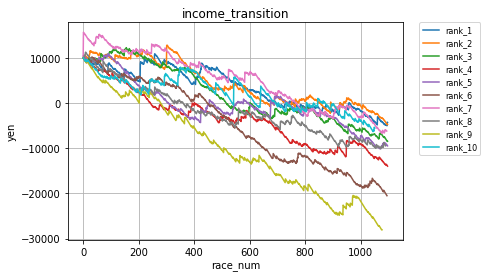

In [ ]:
for i in range(10):
  income_transition(i+1,'f')

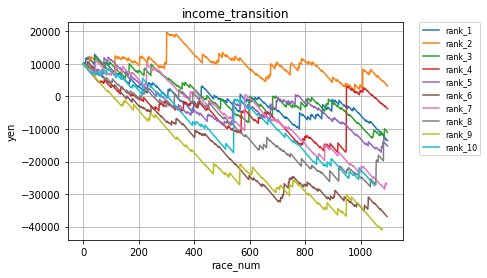

In [ ]:
for i in range(10):
  income_transition(i+1,'t')

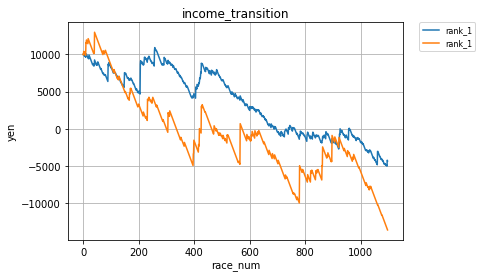

In [ ]:
income_transition(1,'f')
income_transition(1,'t')

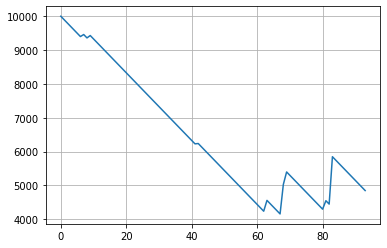

In [ ]:
import matplotlib.pyplot as plt

fukusyo_arr = arr_rank[0].query('dif_rank2 >= 0.05')['row01_今走_馬_複勝配当']
# fukusyo_arr = arr_rank[0].query('dif_rank2 >= 0.02')['row01_今走_馬_単勝配当']

x = fukusyo_arr

y=[]
shisan = 10000
y = [10000]

for i in fukusyo_arr:
    shisan -= 100
    shisan += i
    y.append(shisan)

plt.plot(y)
plt.grid(True)

# 分析表

In [ ]:
def ana_fukusyo(rank):
  global graph

  shisan = 10000

  fukusyo_arr = arr_rank[rank-1]['row01_今走_馬_複勝配当'].dropna().to_list()
  
  income = sum(fukusyo_arr)
  outcome = len(fukusyo_arr)*100
  if outcome > 0:
    income_rate = round(income/outcome*100,3)
  else :
    income_rate = 0

  hit_num = (len(arr_rank[rank-1]['row01_今走_馬_複勝配当']) - len(arr_rank[rank-1][arr_rank[rank-1]['row01_今走_馬_複勝配当']==0]))
  race_num = len(arr_rank[rank-1]['row01_今走_馬_複勝配当']) 

  if race_num > 0:
    hit_rate = round(hit_num/race_num *100,3)
  else :
    hit_rate = 0
 

  graph[rank-1].append(income_rate)
  graph[rank-1].append(income)
  graph[rank-1].append(outcome)
  graph[rank-1].append(hit_rate)
  graph[rank-1].append(hit_num)
  graph[rank-1].append(race_num)


def make_fukusyo_ana():

  for i in range(18):
    ana_fukusyo(i+1)  

graph = [[] for i in range(18)]
make_fukusyo_ana()
df_ana_fukusyo = pd.DataFrame(graph,columns=['income_rate','income','outcome','hitrate','hit_num','race_rum'])

In [ ]:
def ana_tansyo(rank):
  global graph

  shisan = 10000

  tansyo_arr = arr_rank[rank-1]['row01_今走_馬_単勝配当'].dropna().to_list()
  
  income = sum(tansyo_arr)
  outcome = len(tansyo_arr)*100
  if outcome > 0:
    income_rate = round(income/outcome*100,3)
  else :
    income_rate = 0

  hit_num = (len(arr_rank[rank-1]['row01_今走_馬_単勝配当']) - len(arr_rank[rank-1][arr_rank[rank-1]['row01_今走_馬_単勝配当']==0]))
  race_num = len(arr_rank[rank-1]['row01_今走_馬_単勝配当']) 

  if race_num > 0:
    hit_rate = round(hit_num/race_num *100,3)
  else :
    hit_rate = 0
 

  graph[rank-1].append(income_rate)
  graph[rank-1].append(income)
  graph[rank-1].append(outcome)
  graph[rank-1].append(hit_rate)
  graph[rank-1].append(hit_num)
  graph[rank-1].append(race_num)


def make_tansyo_ana():

  for i in range(18):
    ana_tansyo(i+1)  

graph = [[] for i in range(18)]
make_tansyo_ana()
df_ana_tansyo = pd.DataFrame(graph,columns=['income_rate','income','outcome','hitrate','hit_num','race_rum'])


In [ ]:
df_ana_fukusyo

,income_rate,income,outcome,hitrate,hit_num,race_rum
0,86.937,95370,109700,29.353,322,1097
1,86.545,94940,109700,30.629,336,1097
2,83.154,91220,109700,33.090,363,1097
3,78.149,85730,109700,30.811,338,1097
4,82.242,90220,109700,30.811,338,1097
5,72.137,78990,109500,26.027,285,1095
6,85.183,93190,109400,24.954,273,1094
7,82.138,89530,109000,24.954,272,1090
8,64.661,69640,107700,16.620,179,1077
9,85.195,89540,105100,17.317,182,1051


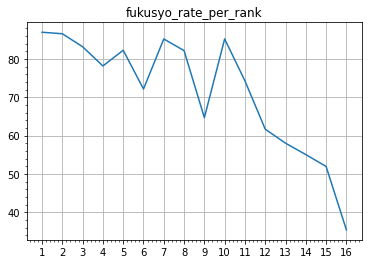

In [ ]:
import matplotlib.pyplot as plt

y = df_ana_fukusyo['income_rate'][:16]

a = [i for i in range(16)]
b = [i+1 for i in range(16)]

plt.plot(y)
plt.title('fukusyo_rate_per_rank')
plt.xticks(a,b)
# plt.ylim(50,120)
plt.minorticks_on()
plt.grid(True,which='major')
# plt.grid(True,which='minor',alpha=0.5)

In [ ]:
df_ana_tansyo

,income_rate,income,outcome,hitrate,hit_num,race_rum
0,78.496,86110,109700,9.936,109,1097
1,93.792,102890,109700,12.033,132,1097
2,80.830,88670,109700,10.757,118,1097
3,87.429,95910,109700,11.212,123,1097
4,76.964,84430,109700,10.939,120,1097
5,57.151,62580,109500,8.493,93,1095
6,66.252,72480,109400,7.404,81,1094
7,78.550,85620,109000,7.798,85,1090
8,52.916,56990,107700,5.385,58,1077
9,64.386,67670,105100,5.233,55,1051


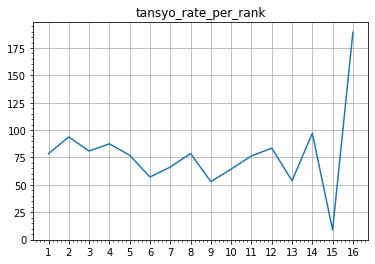

In [ ]:
y = df_ana_tansyo['income_rate'][:16]

a = [i for i in range(16)]
b = [i+1 for i in range(16)]

plt.plot(y)
plt.title('tansyo_rate_per_rank')
plt.xticks(a,b)
plt.minorticks_on()
plt.grid(True,which='major')
# plt.grid(True,which='minor',alpha=0.5)

# ヒストグラム

Text(0.5, 1.0, 'histgram of point rank01')

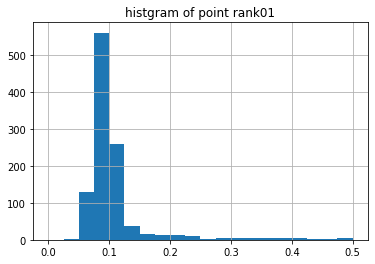

In [ ]:
x = [i for i in range(len(df.query('期待値順位 == 1'))) ]
y = df.query('期待値順位 == 1')['y\''].to_list()

import matplotlib.pyplot as plt

plt.hist(y,range=(0,0.5),bins=20)
plt.grid()
plt.title('histgram of point rank01')

Text(0.5, 1.0, 'histgram of point')

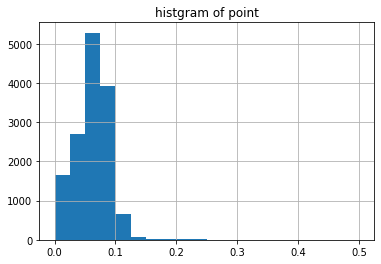

In [ ]:
x = [i for i in range(len(df)) ]
y = df['y\''].to_list()

import matplotlib.pyplot as plt

plt.hist(y,range=(0,0.5),bins=20)
plt.grid()
plt.title('histgram of point')

In [ ]:
def point_income_between(i,x,y,f):
    global graph_point

    if f == 'f':
        opt = 'row01_今走_馬_複勝配当'
    elif f == 't':
        opt = 'row01_今走_馬_単勝配当'

    income_rate = df[(df['y\'']>=x) & (df['y\'']<=y) & (df['期待値順位']==1)][opt].sum()/len(df[(df['y\'']>=x) & (df['y\'']<=y) & (df['期待値順位']==1)])
    graph_point[i].append(round(income_rate,2))
    graph_point[i].append(len(df[(df['y\'']>=x) & (df['y\'']<=y) & (df['期待値順位']==1)]))
    graph_point[i].append(round(x,3))
    graph_point[i].append(round(y,3))

In [ ]:
def point_income_under(x):
  income_rate = df[df['y\'']<=x].query('期待値順位 == 1')['row01_今走_馬_複勝配当'].sum()/len(df[df['y\'']<=x])
  return income_rate,len(df[df['y\'']<=x])

In [ ]:
graph_point = [[] for i in range(11)]


x = 0
i = 0
while x <= 0.5:
  point_income_between(i,x,x+0.05,'f')
  x += 0.05
  i += 1

In [ ]:
df_gp = pd.DataFrame(graph_point,columns = ['rate','race','p_from','p_to'])
df_gp

,rate,race,p_from,p_to
0,0.00,1,0.00,0.05
1,91.36,690,0.05,0.10
2,89.06,298,0.10,0.15
3,80.00,29,0.15,0.20
4,60.48,21,0.20,0.25
5,20.00,8,0.25,0.30
6,46.67,9,0.30,0.35
7,18.89,9,0.35,0.40
8,0.00,6,0.40,0.45
9,0.00,5,0.45,0.50


# 年別集計

In [ ]:
def ana_fukusyo_year(rank,year): 
    global graph

    shisan = 10000

    fukusyo_arr = arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))['row01_今走_馬_複勝配当']) - len(arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[year-2010].append(year)
    graph[year-2010].append(income_rate)
    graph[year-2010].append(income)
    graph[year-2010].append(outcome)
    graph[year-2010].append(hit_rate)
    graph[year-2010].append(hit_num)
    graph[year-2010].append(race_num)
    
def make_fukusyo_ana_year():
    for i in range(2010,2021): ana_fukusyo_year(1,i)

graph = [[] for i in range(11)] 
make_fukusyo_ana_year() 
df_ana_fukusyo_year = pd.DataFrame(graph,columns=['year','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Seri

In [ ]:
df_ana_fukusyo_year

,year,income_rate,income,outcome,hitrate,hit_num,race_rum
0,2010,0.000,0,0,0.000,0,0
1,2011,0.000,0,0,0.000,0,0
2,2012,0.000,0,0,0.000,0,0
3,2013,0.000,0,0,0.000,0,0
4,2014,0.000,0,0,0.000,0,0
5,2015,0.000,0,0,0.000,0,0
6,2016,0.000,0,0,0.000,0,0
7,2017,0.000,0,0,0.000,0,0
8,2018,0.000,0,0,0.000,0,0
9,2019,0.000,0,0,0.000,0,0


In [ ]:
def ana_tansyo_year(rank,year): 
    global graph

    shisan = 10000

    fukusyo_arr = arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))['row01_今走_馬_複勝配当']) - len(arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(arr_rank[rank-1].query('row01_今走_レース_開催年 == '+ str(year))['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[year-2010].append(year)
    graph[year-2010].append(income_rate)
    graph[year-2010].append(income)
    graph[year-2010].append(outcome)
    graph[year-2010].append(hit_rate)
    graph[year-2010].append(hit_num)
    graph[year-2010].append(race_num)
    
def make_fukusyo_ana_year():
    for i in range(2010,2021): ana_fukusyo_year(1,i)

graph = [[] for i in range(11)] 
make_fukusyo_ana_year() 
df_ana_fukusyo_year = pd.DataFrame(graph,columns=['year','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Seri

# 月別集計

In [ ]:
# 年指定なし
def ana_fukusyo_month(rank,month): 
    global graph

    shisan = 10000

    fukusyo_arr = arr_rank[rank-1].query(f'row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(arr_rank[rank-1].query(f'row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_複勝配当']) - len(arr_rank[rank-1].query(f'row01_今走_レース_開催月 == {str(month)}')[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(arr_rank[rank-1].query(f'row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[month-1].append(month)
    graph[month-1].append(income_rate)
    graph[month-1].append(income)
    graph[month-1].append(outcome)
    graph[month-1].append(hit_rate)
    graph[month-1].append(hit_num)
    graph[month-1].append(race_num)
    
def make_fukusyo_ana_month():
    for i in range(12): ana_fukusyo_month(1,i)

graph = [[] for i in range(12)] 
make_fukusyo_ana_month() 
df_ana_fukusyo_month = pd.DataFrame(graph,columns=['month','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_n

In [ ]:
df_ana_fukusyo_month

,month,income_rate,income,outcome,hitrate,hit_num,race_rum
0,1,79.416,12230,15400,21.429,33,154
1,2,131.594,18160,13800,24.638,34,138
2,3,78.834,12850,16300,30.061,49,163
3,4,78.101,12340,15800,25.316,40,158
4,5,99.070,17040,17200,26.744,46,172
5,6,73.115,4460,6100,21.311,13,61
6,7,88.462,3450,3900,35.897,14,39
7,8,0.000,0,0,0.000,0,0
8,9,0.000,0,0,0.000,0,0
9,10,0.000,0,0,0.000,0,0


In [ ]:
# 年指定あり
def ana_fukusyo_month(rank,year,month): 
    global graph

    shisan = 10000

    fukusyo_arr = arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)}  and row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)} and row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_複勝配当']) - len(arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)} and row01_今走_レース_開催月 == {str(month)}')[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)} and row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[month-1].append(month)
    graph[month-1].append(income_rate)
    graph[month-1].append(income)
    graph[month-1].append(outcome)
    graph[month-1].append(hit_rate)
    graph[month-1].append(hit_num)
    graph[month-1].append(race_num)
    
def make_fukusyo_ana_month():
    for i in range(1,12): ana_fukusyo_month(1,2019,i)

graph = [[] for i in range(11)] 
make_fukusyo_ana_month() 
df_ana_fukusyo_month = pd.DataFrame(graph,columns=['month','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_n

In [ ]:
df_ana_fukusyo_month

,month,income_rate,income,outcome,hitrate,hit_num,race_rum
0,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0
5,6,0,0,0,0,0,0
6,7,0,0,0,0,0,0
7,8,0,0,0,0,0,0
8,9,0,0,0,0,0,0
9,10,0,0,0,0,0,0


In [ ]:
# 年指定あり
def ana_tansyo_month(rank,year,month): 
    global graph

    shisan = 10000

    fukusyo_arr = arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)}  and row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_単勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)} and row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_単勝配当']) - len(arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)} and row01_今走_レース_開催月 == {str(month)}')[arr_rank[rank-1]['row01_今走_馬_単勝配当']==0])) 
    race_num = len(arr_rank[rank-1].query(f'row01_今走_レース_開催年 == {str(year)} and row01_今走_レース_開催月 == {str(month)}')['row01_今走_馬_単勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[month-1].append(month)
    graph[month-1].append(income_rate)
    graph[month-1].append(income)
    graph[month-1].append(outcome)
    graph[month-1].append(hit_rate)
    graph[month-1].append(hit_num)
    graph[month-1].append(race_num)
    
def make_tansyo_ana_month():
    for i in range(1,12): ana_tansyo_month(1,2021,i)

graph = [[] for i in range(11)] 
make_tansyo_ana_month() 
df_ana_tansyo_month = pd.DataFrame(graph,columns=['month','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_n

In [ ]:
df_ana_tansyo_month

,month,income_rate,income,outcome,hitrate,hit_num,race_rum
0,1,74.675,11500,15400,7.792,12,154
1,2,86.957,12000,13800,7.246,10,138
2,3,74.356,12120,16300,11.656,19,163
3,4,69.620,11000,15800,8.861,14,158
4,5,79.942,13750,17200,9.302,16,172
5,6,62.295,3800,6100,8.197,5,61
6,7,35.385,1380,3900,7.692,3,39
7,8,0.000,0,0,0.000,0,0
8,9,0.000,0,0,0.000,0,0
9,10,0.000,0,0,0.000,0,0


# オッズ分析

In [ ]:
# 年指定なし
def ana_fukusyo_tanodds(rank,odds): 
    global graph

    shisan = 10000

    fukusyo_arr = arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ <= {odds}')['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ <= {odds}')['row01_今走_馬_複勝配当']) - len(arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ <= {odds}')[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ <= {odds}')['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[rank-1].append(rank)
    graph[rank-1].append(income_rate)
    graph[rank-1].append(income)
    graph[rank-1].append(outcome)
    graph[rank-1].append(hit_rate)
    graph[rank-1].append(hit_num)
    graph[rank-1].append(race_num)
    
def make_fukusyo_ana_odds():
    for i in range(16): 
        ana_fukusyo_tanodds(i,2)

graph = [[] for i in range(16)] 
make_fukusyo_ana_odds() 
df_ana_fukusyo_odds = pd.DataFrame(graph,columns=['rank','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_n

In [ ]:
# 年指定なし
def ana_fukusyo_tanodds(rank,odds): 
    global graph

    shisan = 10000

    fukusyo_arr = arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ >= {odds}')['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ >= {odds}')['row01_今走_馬_複勝配当']) - len(arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ >= {odds}')[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(arr_rank[rank-1].query(f'row01_今走_馬_単勝オッズ >= {odds}')['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[rank-1].append(rank)
    graph[rank-1].append(income_rate)
    graph[rank-1].append(income)
    graph[rank-1].append(outcome)
    graph[rank-1].append(hit_rate)
    graph[rank-1].append(hit_num)
    graph[rank-1].append(race_num)
    
def make_fukusyo_ana_odds():
    for i in range(16): 
        ana_fukusyo_tanodds(i,3)

graph = [[] for i in range(16)] 
make_fukusyo_ana_odds() 
df_ana_fukusyo_odds = pd.DataFrame(graph,columns=['rank','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_n

In [ ]:
df_ana_tansyo_odds

NameError: ignored

# クロス集計

In [ ]:
# 年指定なし
def closs_fukusyo(rank,odds,point): 
    global graph

    shisan = 10000

    where = f'row01_今走_馬_単勝オッズ >= {odds} and p >= {point}'

    ddf = arr_rank[rank-1].rename(columns={'y\'':'p'})

    fukusyo_arr = ddf.query(where)['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(ddf.query(where)['row01_今走_馬_複勝配当']) - len(ddf.query(where)[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(ddf.query(where)['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[rank-1].append(rank)
    graph[rank-1].append(income_rate)
    graph[rank-1].append(income)
    graph[rank-1].append(outcome)
    graph[rank-1].append(hit_rate)
    graph[rank-1].append(hit_num)
    graph[rank-1].append(race_num)
    
def make_closs_fukusyo():
    for i in range(16): 
        closs_fukusyo(i,0,0.2)

graph = [[] for i in range(16)] 
make_closs_fukusyo() 
df_closs_fukusyo = pd.DataFrame(graph,columns=['rank','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

In [ ]:
df_closs_fukusyo

,rank,income_rate,income,outcome,hitrate,hit_num,race_rum
0,1,77.666,29280,37700,16.180,61,377
1,2,100.947,19180,19000,22.105,42,190
2,3,52.804,5650,10700,15.888,17,107
3,4,47.903,2970,6200,12.903,8,62
4,5,54.103,2110,3900,17.949,7,39
5,6,74.615,1940,2600,15.385,4,26
6,7,31.765,540,1700,17.647,3,17
7,8,170.833,2050,1200,41.667,5,12
8,9,251.250,2010,800,12.500,1,8
9,10,0.000,0,400,0.000,0,4


# 2位との期待値差

In [ ]:
def point_income_between(i,x,y,f):
    global graph_point

    if f == 'f':
        opt = 'row01_今走_馬_複勝配当'
    elif f == 't':
        opt = 'row01_今走_馬_単勝配当'

    income_rate = df[(df['dif_rank2']>=x) & (df['dif_rank2']<=y) & (df['期待値順位']==1)][opt].sum()/len(df[(df['dif_rank2']>=x) & (df['dif_rank2']<=y) & (df['期待値順位']==1)])
    graph_point[i].append(round(income_rate,2))
    graph_point[i].append(len(df[(df['dif_rank2']>=x) & (df['dif_rank2']<=y) & (df['期待値順位']==1)]))
    graph_point[i].append(round(x,3))
    graph_point[i].append(round(y,3))

In [ ]:
graph_point = [[] for i in range(30)]


x = 0
i = 0
while x <= 0.05:
  point_income_between(i,x,x+0.005,'f')
  x += 0.005
  i += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [ ]:
df_gp = pd.DataFrame(graph_point,columns = ['rate','race','p_from','p_to'])
df_gp.head(10)

,rate,race,p_from,p_to
0,90.23,861.0,0.000,0.005
1,81.22,188.0,0.005,0.010
2,71.15,26.0,0.010,0.015
3,63.75,8.0,0.015,0.020
4,180.00,1.0,0.020,0.025
5,430.00,2.0,0.025,0.030
6,1120.00,1.0,0.030,0.035
7,NaN,0.0,0.035,0.040
8,0.00,1.0,0.040,0.045
9,NaN,0.0,0.045,0.050


In [ ]:
#  2位との期待値差と期待値のクロス分析
def closs_fukusyo(rank,odds,point): 
    global graph

    shisan = 10000

    where = f'dif_rank2 >= {odds} and p >= {point}'

    ddf = arr_rank[rank-1].rename(columns={'y\'':'p'})

    fukusyo_arr = ddf.query(where)['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(ddf.query(where)['row01_今走_馬_複勝配当']) - len(ddf.query(where)[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(ddf.query(where)['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[rank-1].append(rank)
    graph[rank-1].append(income_rate)
    graph[rank-1].append(income)
    graph[rank-1].append(outcome)
    graph[rank-1].append(hit_rate)
    graph[rank-1].append(hit_num)
    graph[rank-1].append(race_num)
    
def make_closs_fukusyo():
    for i in range(16): 
        closs_fukusyo(i,0.04,0.2)

graph = [[] for i in range(16)] 
make_closs_fukusyo() 
df_closs_fukusyo = pd.DataFrame(graph,columns=['rank','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

In [ ]:
df_closs_fukusyo

,rank,income_rate,income,outcome,hitrate,hit_num,race_rum
0,1,0.0,0,500,0.0,0,5
1,2,0.0,0,0,0.0,0,0
2,3,0.0,0,0,0.0,0,0
3,4,0.0,0,0,0.0,0,0
4,5,0.0,0,0,0.0,0,0
5,6,0.0,0,0,0.0,0,0
6,7,0.0,0,0,0.0,0,0
7,8,0.0,0,0,0.0,0,0
8,9,0.0,0,0,0.0,0,0
9,10,0.0,0,0,0.0,0,0


# 偏差値

In [ ]:
# 1位固定
def point_income_between(i,x,y,f):
    global graph_std

    if f == 'f':
        opt = 'row01_今走_馬_複勝配当'
    elif f == 't':
        opt = 'row01_今走_馬_単勝配当'

    income_rate = df[(df['期待値偏差値']>=x) & (df['期待値偏差値']<=y) & (df['期待値順位']==1)][opt].sum()/len(df[(df['期待値偏差値']>=x) & (df['期待値偏差値']<=y) & (df['期待値順位']==1)])
    graph_std[i].append(round(income_rate,2))
    graph_std[i].append(len(df[(df['期待値偏差値']>=x) & (df['期待値偏差値']<=y) & (df['期待値順位']==1)]))
    graph_std[i].append(round(x,3))
    graph_std[i].append(round(y,3))

In [ ]:
# 1位固定なし
def point_income_between(i,x,y,f):
    global graph_std

    if f == 'f':
        opt = 'row01_今走_馬_複勝配当'
    elif f == 't':
        opt = 'row01_今走_馬_単勝配当'

    income_rate = df[(df['期待値偏差値']>=x) & (df['期待値偏差値']<=y)][opt].sum()/len(df[(df['期待値偏差値']>=x) & (df['期待値偏差値']<=y)])
    graph_std[i].append(round(income_rate,2))
    graph_std[i].append(len(df[(df['期待値偏差値']>=x) & (df['期待値偏差値']<=y)]))
    graph_std[i].append(round(x,3))
    graph_std[i].append(round(y,3))

In [ ]:
graph_std = [[] for i in range(25)]

x = 50
i = 0
while x <= 90:
  point_income_between(i,x,x+2,'f')
  x += 2
  i += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_st = pd.DataFrame(graph_std,columns = ['rate','race','p_from','p_to'])
df_st[4:16]

,rate,race,p_from,p_to
4,80.73,633.0,58.0,60.0
5,86.77,570.0,60.0,62.0
6,73.57,457.0,62.0,64.0
7,86.21,388.0,64.0,66.0
8,91.92,291.0,66.0,68.0
9,106.75,237.0,68.0,70.0
10,79.11,146.0,70.0,72.0
11,105.00,120.0,72.0,74.0
12,88.25,103.0,74.0,76.0
13,90.72,69.0,76.0,78.0


In [ ]:
#  期待値偏差値と期待値のクロス分析
def closs_fukusyo(rank,odds,point): 
    global graph

    shisan = 10000

    where = f'期待値偏差値 >= {odds} and p >= {point}'

    ddf = arr_rank[rank-1].rename(columns={'y\'':'p'})

    fukusyo_arr = ddf.query(where)['row01_今走_馬_複勝配当'].dropna().values

    income = sum(fukusyo_arr) 
    outcome = len(fukusyo_arr)*100 

    if outcome > 0: 
        income_rate = round(income/outcome *100,3) 
    else : income_rate = 0

    hit_num = (len(ddf.query(where)['row01_今走_馬_複勝配当']) - len(ddf.query(where)[arr_rank[rank-1]['row01_今走_馬_複勝配当']==0])) 
    race_num = len(ddf.query(where)['row01_今走_馬_複勝配当'])

    if race_num > 0: 
        hit_rate = round(hit_num/race_num *100,3) 
    else : hit_rate = 0

    graph[rank-1].append(rank)
    graph[rank-1].append(income_rate)
    graph[rank-1].append(income)
    graph[rank-1].append(outcome)
    graph[rank-1].append(hit_rate)
    graph[rank-1].append(hit_num)
    graph[rank-1].append(race_num)
    
def make_closs_fukusyo():
    for i in range(16): 
        closs_fukusyo(i,75,0)

graph = [[] for i in range(16)] 
make_closs_fukusyo() 
df_closs_fukusyo = pd.DataFrame(graph,columns=['rank','income_rate','income','outcome','hitrate','hit_num','race_rum'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

In [ ]:
df_closs_fukusyo

,rank,income_rate,income,outcome,hitrate,hit_num,race_rum
0,1,86.216,25520,29600,24.324,72,296
1,2,0.000,0,0,0.000,0,0
2,3,0.000,0,0,0.000,0,0
3,4,0.000,0,0,0.000,0,0
4,5,0.000,0,0,0.000,0,0
5,6,0.000,0,0,0.000,0,0
6,7,0.000,0,0,0.000,0,0
7,8,0.000,0,0,0.000,0,0
8,9,0.000,0,0,0.000,0,0
9,10,0.000,0,0,0.000,0,0


# ダウンロード

In [ ]:
df.to_csv('evaluation.csv',encoding='SHIFT-JIS',header=True)
df_ana_fukusyo.to_csv('fukusyo_ana.csv',encoding='SHIFT-JIS',header=True)
df_ana_tansyo.to_csv('tansyo_ana.csv',encoding='SHIFT-JIS',header=True)

from google.colab import files
# files.download('evaluation.csv')
# files.download('fukusyo_ana.csv')
# files.download('tansyo_ana.csv')